Plots a histogram to visually communicate temperature anomaly of a day's SST

In [452]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np

In [453]:
def suffix(today):
    updated_day = today.day
    if updated_day == 1:
        suffix = 'st'
    elif updated_day == 2:
        suffix = 'nd'
    elif updated_day == 3:
        suffix = 'rd'
    elif (4 <= updated_day <= 20):
        suffix = 'th'
    elif updated_day == 21:
        suffix = 'st'
    elif updated_day == 22:
        suffix = 'nd'
    elif updated_day == 23:
        suffix = 'rd'
    elif (24 <= updated_day <= 30):
        suffix = 'th'
    elif updated_day == 31:
        suffix = 'st'
    return suffix

In [454]:
def trivia_msg(climatology, today_sst, today):
    trivia_msg = None
    #TODO make cooler warmer the color of the bin in the histogram
    if today_sst > climatology.SURF_TEMP_C.mean():
        trivia_msg = 'Today is warmer than the average \n of all ' + today.strftime('%B %-d') + suffix(today) + 's, but not by much.' #TODO implement  std gate
    elif today_sst < climatology.SURF_TEMP_C.mean():
        trivia_msg = 'Today is cooler than the average \n of all ' + today.strftime('%B %-d') + suffix(today) + 's, but not by much.'
    if today_sst > np.nanpercentile(climatology.SURF_TEMP_C.values,90): #How do you define a MHW day? Also np.percentile assumes a normal distribution I think
        trivia_msg = 'Today is among the hottest 10% \nof ' + today.strftime('%B %-d') + suffix(today) + 's on record.'
    if today_sst < np.nanpercentile(climatology.SURF_TEMP_C.values,10): #How do you define a MHW day? Also np.percentile assumes a normal distribution I think
        trivia_msg = 'Today is among the coldest 10% \nof ' + today.strftime('%B %-d') + suffix(today) + 's on record.'
    if today_sst >= climatology.SURF_TEMP_C.max():
        trivia_msg = 'Today is the hottest \n' + today.strftime('%B %-d') + suffix(today) + ' on record.'
    elif today_sst <= climatology.SURF_TEMP_C.min():
        trivia_msg = 'Today is the coldest \n' + today.strftime('%B %-d') + suffix(today) + ' on record.'
    #TODO add coldest 10%
    return trivia_msg

In [455]:
sst_filename='SIO_TEMP_20230105.csv'
all_sst = pd.read_csv(sst_filename, usecols = ['SURF_TEMP_C','MONTH','DAY','YEAR'])
today = datetime(2023,9,27)
day = today.day
month = today.month
today_sst = 21 #TODO automate, add exception for when data isn't taken
climatology = all_sst[(all_sst['MONTH'] == month) & (all_sst['DAY'] == day)]
climatology.sort_values(by='SURF_TEMP_C', ascending=False)

,SURF_TEMP_C,YEAR,MONTH,DAY
36195,24.7,2015,9,27
38752,22.5,2022,9,27
24873,22.3,1984,9,27
5514,22.0,1931,9,27
29621,22.0,1997,9,27
...,...,...,...,...
30351,16.4,1999,9,27
15011,16.2,1957,9,27
8071,16.1,1938,9,27
16472,16.1,1961,9,27


In [456]:
def sst_hist(sst_filename, location):
    all_sst = pd.read_csv(sst_filename, usecols = ['SURF_TEMP_C','MONTH','DAY','YEAR'])
    today = datetime(2023,10,4) #TODO change to just doing last row
    day = today.day
    month = today.month
    today_sst = 16 #TODO automate, add exception for when data isn't taken
    today_suffix = suffix(today)
    climatology = all_sst[(all_sst['MONTH'] == month) & (all_sst['DAY'] == day)]
    max_day = all_sst.loc[climatology.SURF_TEMP_C.idxmax()]
    min_day = all_sst.loc[climatology.SURF_TEMP_C.idxmin()]
    mean = climatology.SURF_TEMP_C.mean()
    max_msg = 'Record High SST: '  + str(max_day.SURF_TEMP_C) + 'ºC in ' + str(int(max_day.YEAR))
    min_msg = 'Record Low SST: '  + str(min_day.SURF_TEMP_C) + 'ºC in ' + str(int(min_day.YEAR))
    mean_msg = 'Average SST: ' + str(round(mean,1)) + 'ºC'
    
            

    cm = plt.colormaps.get_cmap('RdBu_r')
    n, bins, patches = plt.hist(climatology.SURF_TEMP_C, bins = 20)
    plt.axvline(today_sst, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(mean, color='k', linestyle='dotted', linewidth=1, c= '#404040')
    ylim = plt.gca().get_ylim()
    top = ylim[1]
    bottom = ylim[0]
    xlim = plt.gca().get_xlim()
    left = xlim[0]
    right = xlim[1]
    y_range = top - bottom
    temp_label_x = today_sst + 0.1 if today_sst > mean else today_sst - 0.2
    plt.text(temp_label_x, top - y_range * 0.4, "Today's Temperature", rotation =90)
    plt.text(mean - 0.3, bottom + 0.4, "Average SST", c='#404040', rotation =90)
    plt.xlabel('Temperature (ºC)')
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.ylabel('Frequency')
    #plt.title('Temperature Distribution of all '+today.strftime("%b %d")+ today_suffix + 's at '+location) #TODO come up with better title
    plt.text(right + 0.1, top - 1, max_msg, fontsize=10, color='#67001F')
    plt.text(right + 0.1, top - 2, min_msg, fontsize=10, color='#053061')
    plt.text(right + 0.1, top - 3, mean_msg, fontsize=10, c='k')
    plt.text(right + 0.1, bottom, trivia_msg(climatology, today_sst, today), fontsize=10, color='#252385')
    #TODO move comments from other .ipynb

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
        
    fig_filename = 'sst_hist'+today.strftime("%m_%d_%Y")+location.replace(' ', '_')+".png"
    plt.savefig(fig_filename)
    plt.show()

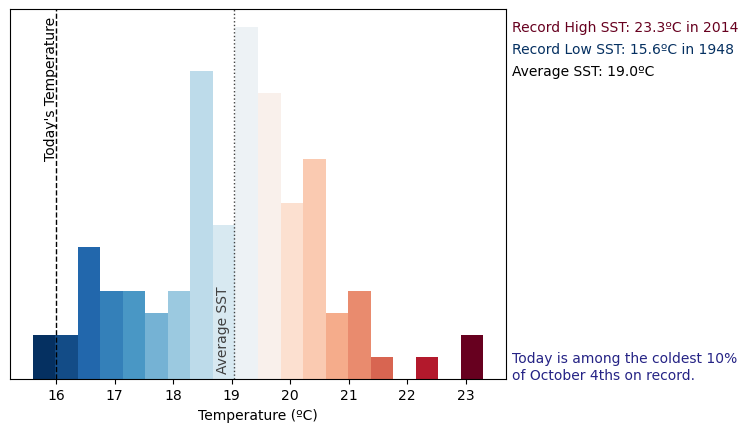

In [457]:
sst_filename='SIO_TEMP_20230105.csv'
location = 'SIO Pier'

sst_hist(sst_filename, location)